# Brownian Motion Diffusion Analysis
> Ahilan Kumaresan

This code has been Built with ideas inspired by the Reference code the Prof has in Canvas, along with using an LLM. 

_Analysis of multiple bead sizes for diffusion coefficient comparison_

This notebook performs complete diffusion analysis including:
1. Loading MTrack2 data for multiple bead sizes
2. Track splitting at large jumps (preserves more data)
3. Displacement histogram and Gaussian fitting
4. Direct calculation of diffusion coefficient from variance
5. Mean-Squared Displacement (MSD) analysis
6. Comparison with Stokes-Einstein theory
7. **Comparison between bead sizes**

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from numpy import pi, exp, sqrt
import warnings
warnings.filterwarnings("ignore")

# ============================================================================
# CONTROL VARIABLES - MODIFY THESE BEFORE RUNNING
# ============================================================================

# Data file paths for each bead size
# Format: {bead_diameter_um: file_path}
DATA_FILES = {
    1.0: "../Data/2026-02-05/1mu-21c-1isto224w-0_5p-trackresults.txt",   # 1 micron beads (75 particles)
    5.0: "../Data/2026-02-05/5mu-21c-1isto6_5w-0_5p-trackresults.txt",   # 5 micron beads (17 particles)
}

# Number of best track segments to use (ranked by length)
NUM_BEST_SEGMENTS = 10  # <select top N track segments

# Minimum track segment length required (frames)
MIN_TRACK_LENGTH = 20  # <-- Segments must have at least this many frames

# Whether to subtract mean displacement (removes drift)
SUBTRACT_DRIFT = True

# Maximum allowed displacement per frame (pixels) - tracks SPLIT at larger jumps
# This splits tracks into valid segments rather than discarding entire tracks
MAX_DISPLACEMENT_PER_FRAME = 20  # pixels - tracks split at jumps larger than this

# === Experimental Parameters ===
FRAME_RATE = 226       # fps (frames per second)
PIXEL_SIZE = 0.345     # microns per pixel (345 nm)
TEMPERATURE = 294.15   # Kelvin (21C)
VISCOSITY = 0.0009764  # Pa.s (water at 21C)

# Physical constants
k_B = 1.381e-23  # Boltzmann constant (J/K)

# ============================================================================
print("CONTROL VARIABLES SET")
print(f"  Data files: {len(DATA_FILES)} bead sizes")
for d, path in DATA_FILES.items():
    print(f"    {d} um: {path.split('/')[-1]}")
print(f"  Using top {NUM_BEST_SEGMENTS} track segments")
print(f"  Min track length: {MIN_TRACK_LENGTH} frames")
print(f"  Track split threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame")
print(f"  Drift correction: {'ON' if SUBTRACT_DRIFT else 'OFF'}")
print(f"\nExperimental parameters:")
print(f"  Frame rate: {FRAME_RATE} fps")
print(f"  Pixel size: {PIXEL_SIZE*1000:.1f} nm/px")
print(f"  Temperature: {TEMPERATURE} K ({TEMPERATURE-273.15:.1f} C)")

CONTROL VARIABLES SET
  Data files: 2 bead sizes
    1.0 um: 1mu-21c-1isto224w-0_5p-trackresults.txt
    5.0 um: 5mu-21c-1isto6_5w-0_5p-trackresults.txt
  Using top 10 track segments
  Min track length: 20 frames
  Track split threshold: 20 px/frame
  Drift correction: ON

Experimental parameters:
  Frame rate: 226 fps
  Pixel size: 345.0 nm/px
  Temperature: 294.15 K (21.0 C)


## Helper Functions

Functions for loading data, splitting tracks at jumps, and performing analysis.

> **Source:** Data loading adapted from `LabLevel References/Reference-code/Python demos/MTrack2Loader.ipynb` (Rev11 250919 DAL, Physics SFU). Modified: fixed dtype bug (`np.int` -> `int`), added `invalid_raise=False`. Track splitting logic added to preserve more data by splitting at large jumps instead of discarding.

In [1]:
def load_mtrack2_data(file_path):
    """
    Load MTrack2 output file and return cleaned data matrix.
    
    Returns:
        data: numpy array with shape (frames, 2*particles) containing X,Y pairs
    """
    my_data = np.genfromtxt(file_path, delimiter='\t', skip_header=2, 
                           skip_footer=1, invalid_raise=False)
    
    # Remove indexer, summary box and Flags column
    A = np.zeros(my_data.shape[1]//3+1, dtype=int)
    for i in range(my_data.shape[1]//3+1):
        A[i] = 3*i
    new_data = np.delete(my_data, A, axis=1)
    
    # Sort data - move NaN values to the end
    mask = np.isnan(new_data)
    new_mask = np.zeros(mask.shape)
    for ind, value in enumerate(mask):
        new_mask[ind, :] = ~value * (ind + 1)
    new_mask = new_mask.astype(np.int_)
    
    for row_index, row in enumerate(new_mask):
        for col_index, item in enumerate(row):
            if item == 0:
                new_mask[row_index][col_index] = (new_mask.shape[0] + 5)
    
    for i in range(new_mask.shape[1]):
        new_mask[:, i] = np.sort(new_mask[:, i])
    
    data = np.empty((mask.shape[0], mask.shape[1]))
    data[:, :] = np.nan
    
    for i in range(new_mask.shape[0]):
        for j in range(new_mask.shape[1]):
            temp = new_mask[i, j]
            if temp < (new_mask.shape[0]):
                data[i, j] = new_data[temp, j]
    
    return data


def split_tracks_at_jumps(data, min_length, max_jump_px):
    """
    Extract valid trajectory segments from raw data.
    SPLITS tracks at large jumps (tracking errors) instead of discarding entire tracks.
    
    Parameters:
        data: Raw X,Y data (rows=frames, columns=X1,Y1,X2,Y2,...)
        min_length: Minimum number of points for a valid segment
        max_jump_px: Maximum allowed jump per frame (pixels) - tracks split here
    
    Returns:
        List of trajectory dicts with 'x', 'y', 'id' keys
    """
    segments = []
    n_particles = data.shape[1] // 2
    segment_id = 0
    
    for i in range(n_particles):
        x_col = i * 2
        y_col = i * 2 + 1
        
        # Extract track
        x_raw = data[:, x_col]
        y_raw = data[:, y_col]
        
        # Remove NaNs (get valid indices)
        valid_mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
        x_clean = x_raw[valid_mask]
        y_clean = y_raw[valid_mask]
        
        if len(x_clean) < min_length:
            continue
        
        # Calculate step sizes
        dx = np.diff(x_clean)
        dy = np.diff(y_clean)
        steps = np.sqrt(dx**2 + dy**2)
        
        # Find indices where jumps exceed threshold
        bad_jump_indices = np.where(steps > max_jump_px)[0]
        
        if len(bad_jump_indices) == 0:
            # No bad jumps - use entire track as one segment
            segment_id += 1
            segments.append({
                'x': x_clean,
                'y': y_clean,
                'id': segment_id,
                'original_particle': i + 1,
                'length': len(x_clean)
            })
        else:
            # Split at bad jump locations
            split_indices = bad_jump_indices + 1
            x_segments = np.split(x_clean, split_indices)
            y_segments = np.split(y_clean, split_indices)
            
            for x_seg, y_seg in zip(x_segments, y_segments):
                if len(x_seg) >= min_length:
                    segment_id += 1
                    segments.append({
                        'x': x_seg,
                        'y': y_seg,
                        'id': segment_id,
                        'original_particle': i + 1,
                        'length': len(x_seg)
                    })
    
    # Sort by length (longest first)
    segments.sort(key=lambda s: s['length'], reverse=True)
    
    return segments


def gaussian(x, amplitude, mean, std_dev):
    """Gaussian function for curve fitting."""
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))


def linear(t, slope, intercept):
    """Linear function for MSD fitting."""
    return slope * t + intercept


## Main Analysis Function

This function performs the complete diffusion analysis for a single bead size.

In [ ]:
def analyze_bead_size(file_path, bead_diameter, label):
    """
    Perform complete diffusion analysis for one bead size.
    
    Parameters:
        file_path: Path to MTrack2 results file
        bead_diameter: Bead diameter in micrometers
        label: String label for plots
    
    Returns:
        Dictionary with all results
    """
    results = {'bead_diameter': bead_diameter, 'label': label}
    
    # Derived parameters
    dt = 1 / FRAME_RATE
    r = (bead_diameter / 2) * 1e-6  # radius in meters
    
    # Theoretical D (Stokes-Einstein)
    D_theory = k_B * TEMPERATURE / (6 * np.pi * VISCOSITY * r)
    D_theory_um = D_theory * 1e12  # Convert to um^2/s
    results['D_theory'] = D_theory_um
    
    # ========================================================================
    # LOAD DATA
    # ========================================================================
    print("=" * 60)
    print(f"ANALYZING {label}")
    print("=" * 60)
    
    try:
        data = load_mtrack2_data(file_path)
    except Exception as e:
        print(f"ERROR loading file: {e}")
        print(f"  File path: {file_path}")
        return None
    
    total_frames = data.shape[0]
    total_particles = data.shape[1] // 2
    
    print(f"\nFile: {file_path.split('/')[-1]}")
    print(f"Total frames: {total_frames}")
    print(f"Total particles detected: {total_particles}")
    
    # ========================================================================
    # SPLIT TRACKS AT LARGE JUMPS
    # ========================================================================
    segments = split_tracks_at_jumps(data, MIN_TRACK_LENGTH, MAX_DISPLACEMENT_PER_FRAME)
    
    print(f"\nTrack splitting (threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame):")
    print(f"  Valid segments extracted: {len(segments)}")
    print(f"  (Min segment length: {MIN_TRACK_LENGTH} frames)")
    
    if len(segments) == 0:
        print("WARNING: No valid segments! Try adjusting parameters.")
        return None
    
    # Select top segments
    n_to_use = min(NUM_BEST_SEGMENTS, len(segments))
    selected_segments = segments[:n_to_use]
    
    print(f"\nUsing top {n_to_use} segments:")
    print(f"  {'Seg':<5} {'Orig Part':<10} {'Frames':<8}")
    print(f"  {'-'*25}")
    for seg in selected_segments[:10]:  # Show max 10
        print(f"  {seg['id']:<5} {seg['original_particle']:<10} {seg['length']:<8}")
    
    results['n_segments'] = n_to_use
    results['segments'] = selected_segments
    
    # ========================================================================
    # EXTRACT DISPLACEMENTS
    # ========================================================================
    all_dx = []
    all_dy = []
    
    for seg in selected_segments:
        dx_seg = np.diff(seg['x'])
        dy_seg = np.diff(seg['y'])
        all_dx.extend(dx_seg)
        all_dy.extend(dy_seg)
    
    dx = np.array(all_dx)
    dy = np.array(all_dy)
    
    # Apply drift correction if enabled
    if SUBTRACT_DRIFT and len(dx) > 0:
        mean_dx = np.mean(dx)
        mean_dy = np.mean(dy)
        dx = dx - mean_dx
        dy = dy - mean_dy
        print(f"\nDrift correction applied:")
        print(f"  Mean dx removed: {mean_dx:.4f} px ({mean_dx*PIXEL_SIZE*1000:.1f} nm)")
        print(f"  Mean dy removed: {mean_dy:.4f} px ({mean_dy*PIXEL_SIZE*1000:.1f} nm)")
    
    print(f"\nTotal displacement steps: {len(dx)}")
    print(f"  dx: std = {np.std(dx):.4f} px ({np.std(dx)*PIXEL_SIZE*1000:.1f} nm)")
    print(f"  dy: std = {np.std(dy):.4f} px ({np.std(dy)*PIXEL_SIZE*1000:.1f} nm)")
    
    results['dx'] = dx
    results['dy'] = dy
    results['n_steps'] = len(dx)
    
    # ========================================================================
    # METHOD 1: DIRECT VARIANCE CALCULATION
    # ========================================================================
    var_dx = np.var(dx)  # px^2
    var_dy = np.var(dy)  # px^2
    var_dx_um = var_dx * PIXEL_SIZE**2  # um^2
    var_dy_um = var_dy * PIXEL_SIZE**2  # um^2
    
    D_x_direct = var_dx_um / (2 * dt)
    D_y_direct = var_dy_um / (2 * dt)
    D_avg_direct = (D_x_direct + D_y_direct) / 2
    
    print(f"\n" + "-" * 40)
    print(f"METHOD 1: Direct Variance")
    print(f"-" * 40)
    print(f"  D_x = {D_x_direct:.4f} um^2/s")
    print(f"  D_y = {D_y_direct:.4f} um^2/s")
    print(f"  D_avg = {D_avg_direct:.4f} um^2/s")
    print(f"  D_theory = {D_theory_um:.4f} um^2/s")
    print(f"  Ratio = {D_avg_direct/D_theory_um:.2f}x")
    
    results['D_direct'] = D_avg_direct
    results['var_dx'] = var_dx
    results['var_dy'] = var_dy
    
    # ========================================================================
    # METHOD 2: GAUSSIAN FIT TO HISTOGRAM
    # ========================================================================
    nbins = 20
    
    # Fit X
    counts_x, bins_x = np.histogram(dx, bins=nbins, density=True)
    bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
    try:
        p0_x = [max(counts_x), np.mean(dx), np.std(dx)]
        popt_x, pcov_x = curve_fit(gaussian, bin_centers_x, counts_x, p0=p0_x)
        std_x_fit = abs(popt_x[2])
    except:
        std_x_fit = np.std(dx)
    
    # Fit Y
    counts_y, bins_y = np.histogram(dy, bins=nbins, density=True)
    bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
    try:
        p0_y = [max(counts_y), np.mean(dy), np.std(dy)]
        popt_y, pcov_y = curve_fit(gaussian, bin_centers_y, counts_y, p0=p0_y)
        std_y_fit = abs(popt_y[2])
    except:
        std_y_fit = np.std(dy)
    
    var_x_fit_um = (std_x_fit * PIXEL_SIZE)**2
    var_y_fit_um = (std_y_fit * PIXEL_SIZE)**2
    D_x_fit = var_x_fit_um / (2 * dt)
    D_y_fit = var_y_fit_um / (2 * dt)
    D_avg_fit = (D_x_fit + D_y_fit) / 2
    
    print(f"\n" + "-" * 40)
    print(f"METHOD 2: Gaussian Fit")
    print(f"-" * 40)
    print(f"  sigma_x = {std_x_fit:.4f} px")
    print(f"  sigma_y = {std_y_fit:.4f} px")
    print(f"  D_avg = {D_avg_fit:.4f} um^2/s")
    print(f"  Ratio = {D_avg_fit/D_theory_um:.2f}x")
    
    results['D_fit'] = D_avg_fit
    results['std_x_fit'] = std_x_fit
    results['std_y_fit'] = std_y_fit
    
    # ========================================================================
    # METHOD 3: MSD ANALYSIS
    # ========================================================================
    # Find minimum track length
    min_track = min([seg['length'] for seg in selected_segments])
    max_lag = min(min_track // 2, 30)  # Cap at 30 for stability
    
    # Calculate MSD for each segment
    all_MSDs = []
    for seg in selected_segments:
        x = seg['x'].copy()
        y = seg['y'].copy()
        
        if SUBTRACT_DRIFT:
            x = x - np.mean(x)
            y = y - np.mean(y)
        
        MSD_seg = np.zeros(max_lag)
        n_frames = len(x)
        
        for lag in range(max_lag):
            if n_frames > lag:
                dx_lag = x[lag:] - x[:-lag] if lag > 0 else np.zeros(n_frames)
                dy_lag = y[lag:] - y[:-lag] if lag > 0 else np.zeros(n_frames)
                r_sq = dx_lag**2 + dy_lag**2
                MSD_seg[lag] = np.mean(r_sq) if len(r_sq) > 0 else 0
        
        all_MSDs.append(MSD_seg)
    
    all_MSDs = np.array(all_MSDs)
    MSD = np.mean(all_MSDs, axis=0)
    MSD_err = np.std(all_MSDs, axis=0) / np.sqrt(len(selected_segments))
    
    # Convert to physical units
    MSD_um = MSD * PIXEL_SIZE**2
    MSD_err_um = MSD_err * PIXEL_SIZE**2
    lag_times = np.arange(max_lag) * dt
    
    # Fit linear region (exclude lag=0)
    n_fit = min(15, max_lag // 2)
    fit_times = lag_times[1:n_fit+1]
    fit_MSD = MSD_um[1:n_fit+1]
    fit_err = MSD_err_um[1:n_fit+1]
    
    # Handle zero errors
    fit_err = np.where(fit_err > 0, fit_err, 1e-10)
    
    try:
        popt_msd, pcov_msd = curve_fit(linear, fit_times, fit_MSD,
                                        sigma=fit_err, absolute_sigma=True,
                                        p0=[1, 0])
        perr_msd = np.sqrt(np.diag(pcov_msd))
        slope = popt_msd[0]
        slope_err = perr_msd[0]
    except:
        # Simple linear fit without weights
        coeffs = np.polyfit(fit_times, fit_MSD, 1)
        slope = coeffs[0]
        slope_err = 0
    
    D_msd = slope / 4  # For 2D: MSD = 4*D*t
    D_msd_err = slope_err / 4
    
    print(f"\n" + "-" * 40)
    print(f"METHOD 3: MSD Slope")
    print(f"-" * 40)
    print(f"  Slope = {slope:.4f} +/- {slope_err:.4f} um^2/s")
    print(f"  D_MSD = {D_msd:.4f} +/- {D_msd_err:.4f} um^2/s")
    print(f"  Ratio = {D_msd/D_theory_um:.2f}x")
    
    results['D_msd'] = D_msd
    results['D_msd_err'] = D_msd_err
    results['MSD_um'] = MSD_um
    results['MSD_err_um'] = MSD_err_um
    results['lag_times'] = lag_times
    results['msd_slope'] = slope
    
    return results


Analysis function defined.


## Run Analysis for All Bead Sizes

In [4]:
# Store results for all bead sizes
all_results = {}

for bead_diameter, file_path in DATA_FILES.items():
    label = f"{bead_diameter} um beads"
    result = analyze_bead_size(file_path, bead_diameter, label)
    if result is not None:
        all_results[bead_diameter] = result
    print("\n")

ANALYZING 1.0 um beads

File: 1mu-21c-1isto224w-0_5p-trackresults.txt
Total frames: 240
Total particles detected: 75

Track splitting (threshold: 20 px/frame):
  Valid segments extracted: 64
  (Min segment length: 20 frames)

Using top 10 segments:
  Seg   Orig Part  Frames  
  -------------------------
  25    13         235     
  26    14         235     
  27    15         235     
  32    19         234     
  38    22         234     
  11    5          230     
  20    10         230     
  31    18         230     
  16    8          225     
  28    16         218     

Drift correction applied:
  Mean dx removed: 0.0094 px (3.3 nm)
  Mean dy removed: 0.0260 px (9.0 nm)

Total displacement steps: 2296
  dx: std = 0.8068 px (278.3 nm)
  dy: std = 0.8026 px (276.9 nm)

----------------------------------------
METHOD 1: Direct Variance
----------------------------------------
  D_x = 8.7545 um^2/s
  D_y = 8.6638 um^2/s
  D_avg = 8.7092 um^2/s
  D_theory = 0.4414 um^2/s
  Ratio = 

## Visualize Particle Trajectories

2D tracks for each bead size.

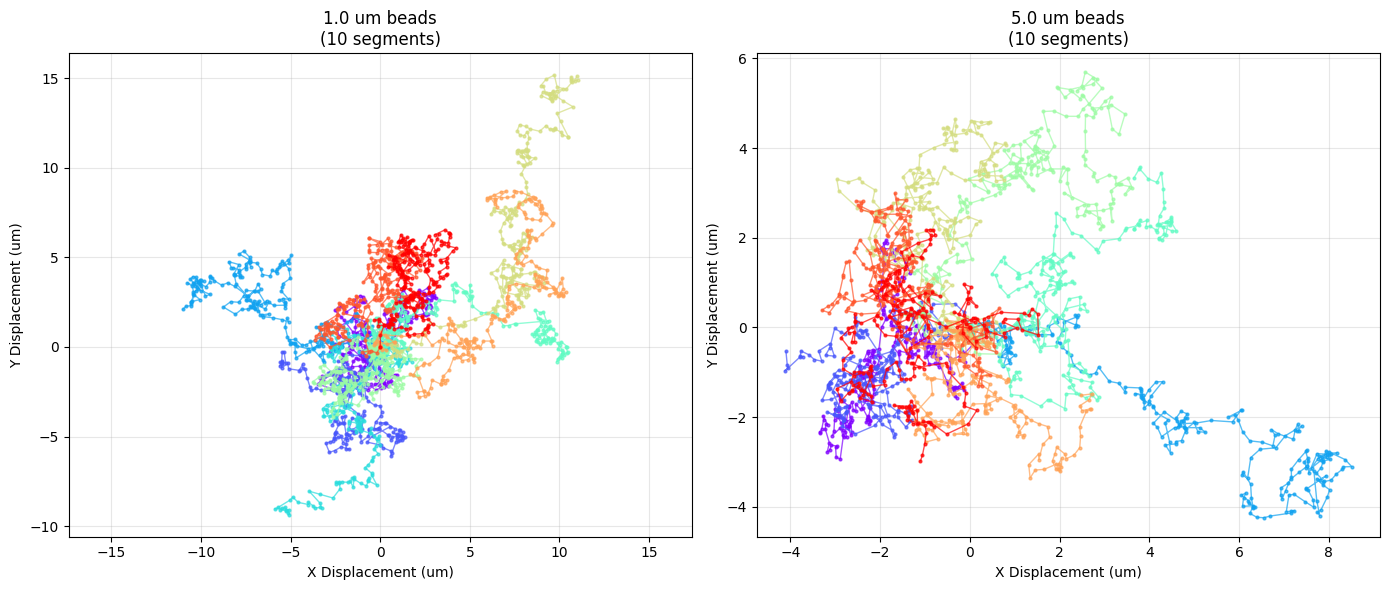

In [5]:
# Plot trajectories for each bead size
n_sizes = len(all_results)
if n_sizes > 0:
    fig, axes = plt.subplots(1, n_sizes, figsize=(7*n_sizes, 6))
    if n_sizes == 1:
        axes = [axes]
    
    for ax, (bead_d, res) in zip(axes, all_results.items()):
        segments = res['segments'][:10]  # Show top 10
        colors = cm.rainbow(np.linspace(0, 1, len(segments)))
        
        for seg, c in zip(segments, colors):
            x_um = seg['x'] * PIXEL_SIZE
            y_um = seg['y'] * PIXEL_SIZE
            # Plot relative to start
            ax.plot(x_um - x_um[0], y_um - y_um[0], '-o', 
                    markersize=2, linewidth=1, color=c, alpha=0.7)
        
        ax.set_xlabel('X Displacement (um)')
        ax.set_ylabel('Y Displacement (um)')
        ax.set_title(f'{res["label"]}\n({res["n_segments"]} segments)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## Displacement Histograms

Plot histogram of X and Y displacements for each bead size.

> **Source:** Histogram plotting and error bar calculation adapted from `LabLevel References/Reference-code/Python demos/histogram_demo_using_data.ipynb` (Rev12 Feb. 18, 2021, JB, Physics SFU).

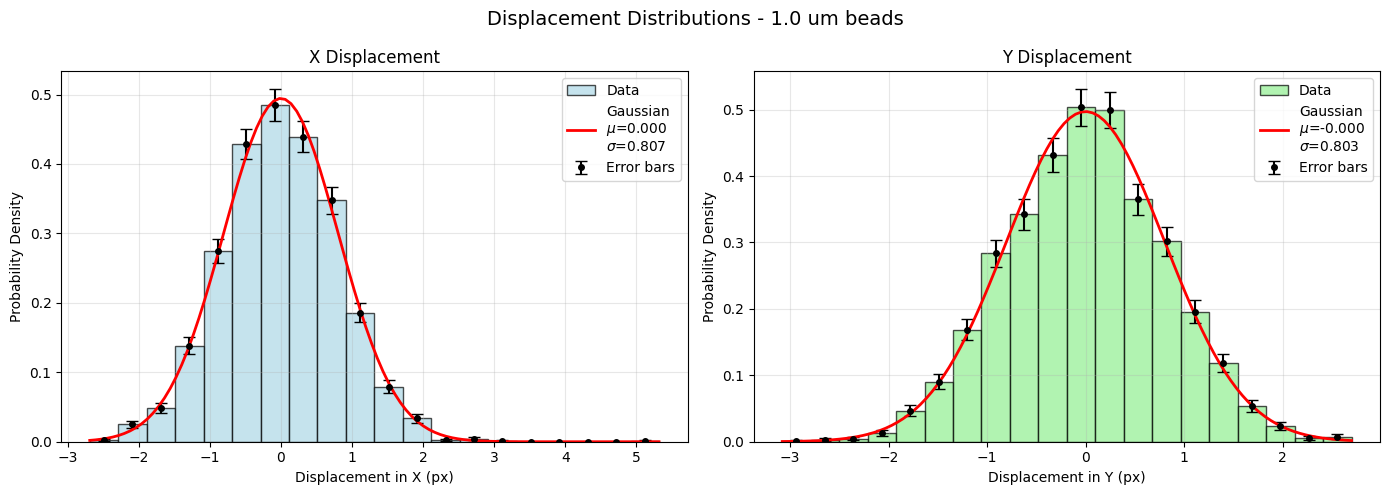

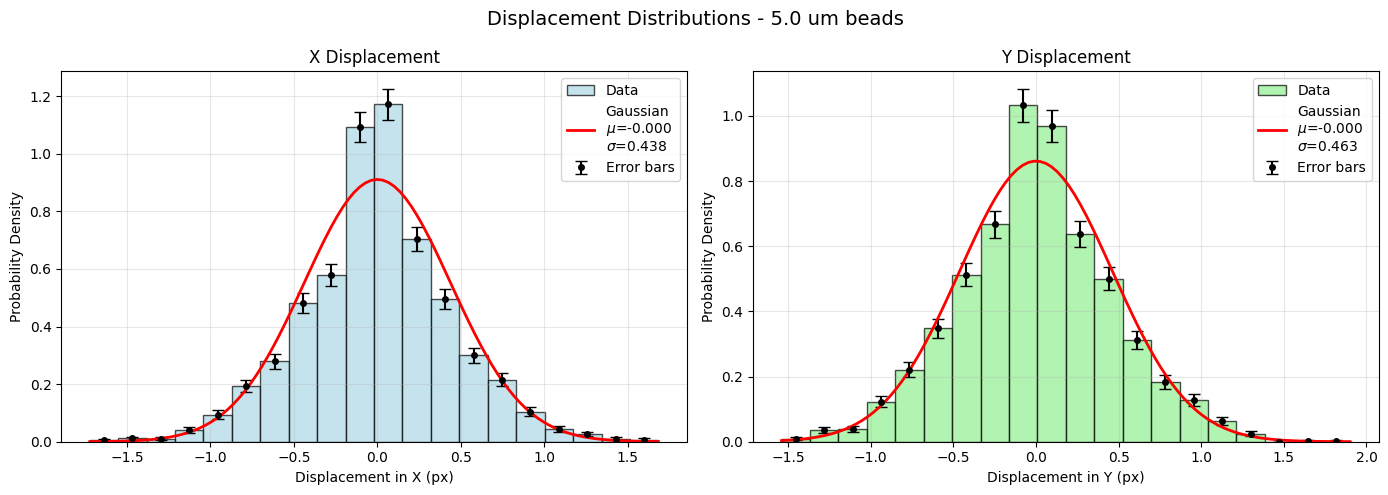

In [6]:
# Displacement histograms for each bead size
for bead_d, res in all_results.items():
    dx = res['dx']
    dy = res['dy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Displacement Distributions - {res["label"]}', fontsize=14)
    
    nbins = 20
    
    # X histogram
    counts_x, bins_x, _ = ax1.hist(dx, bins=nbins, density=True, alpha=0.7,
                                    color='lightblue', edgecolor='black', label='Data')
    bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
    
    # Error bars (Poisson)
    counts_raw_x, _ = np.histogram(dx, bins=nbins)
    bin_widths_x = np.diff(bins_x)
    counts_err_x = np.sqrt(counts_raw_x) / (len(dx) * bin_widths_x)
    ax1.errorbar(bin_centers_x, counts_x, yerr=counts_err_x, fmt='ko',
                 markersize=4, capsize=4, label='Error bars')
    
    # Gaussian overlay
    mean_x = np.mean(dx)
    std_x = np.std(dx)
    x_range = np.linspace(dx.min(), dx.max(), 100)
    gaussian_x = (1/(sqrt(2*pi)*std_x)) * exp(-(x_range - mean_x)**2 / (2*std_x**2))
    ax1.plot(x_range, gaussian_x, 'r-', linewidth=2,
             label=f'Gaussian\n$\mu$={mean_x:.3f}\n$\sigma$={std_x:.3f}')
    
    ax1.set_xlabel('Displacement in X (px)')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('X Displacement')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Y histogram
    counts_y, bins_y, _ = ax2.hist(dy, bins=nbins, density=True, alpha=0.7,
                                    color='lightgreen', edgecolor='black', label='Data')
    bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
    
    counts_raw_y, _ = np.histogram(dy, bins=nbins)
    bin_widths_y = np.diff(bins_y)
    counts_err_y = np.sqrt(counts_raw_y) / (len(dy) * bin_widths_y)
    ax2.errorbar(bin_centers_y, counts_y, yerr=counts_err_y, fmt='ko',
                 markersize=4, capsize=4, label='Error bars')
    
    mean_y = np.mean(dy)
    std_y = np.std(dy)
    y_range = np.linspace(dy.min(), dy.max(), 100)
    gaussian_y = (1/(sqrt(2*pi)*std_y)) * exp(-(y_range - mean_y)**2 / (2*std_y**2))
    ax2.plot(y_range, gaussian_y, 'r-', linewidth=2,
             label=f'Gaussian\n$\mu$={mean_y:.3f}\n$\sigma$={std_y:.3f}')
    
    ax2.set_xlabel('Displacement in Y (px)')
    ax2.set_ylabel('Probability Density')
    ax2.set_title('Y Displacement')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Mean-Squared Displacement (MSD) Analysis

Calculate MSD as a function of lag time:

$$\text{MSD}(\tau) = \langle [r(t+\tau) - r(t)]^2 \rangle$$

For 2D diffusion: MSD = 4D*tau

> **Source:** MSD calculation adapted from `LabLevel References/Reference-code/Python demos/diffusion_analysis_demo.ipynb` (Rev12 071119 DAL, Physics SFU).

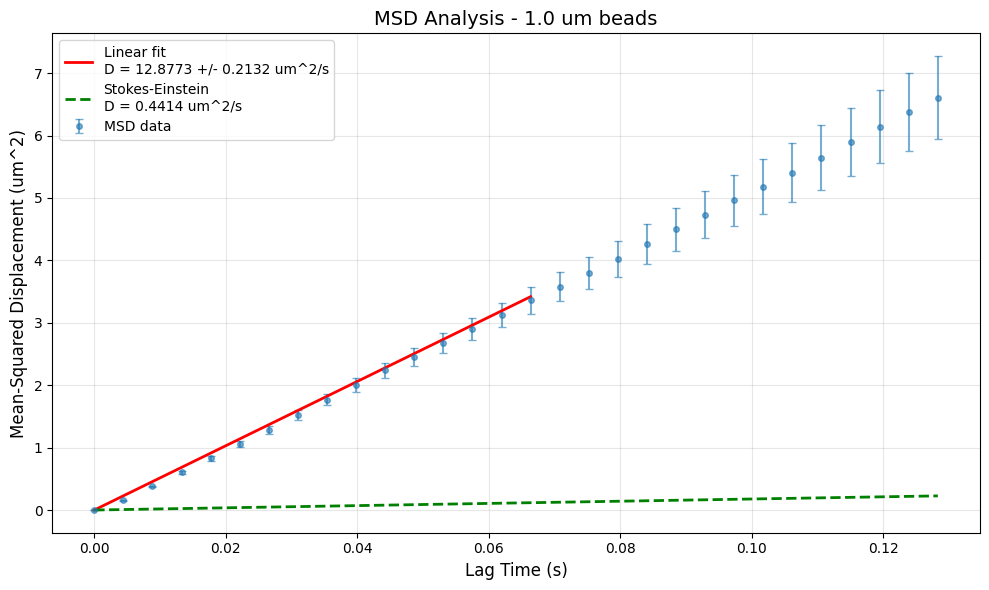

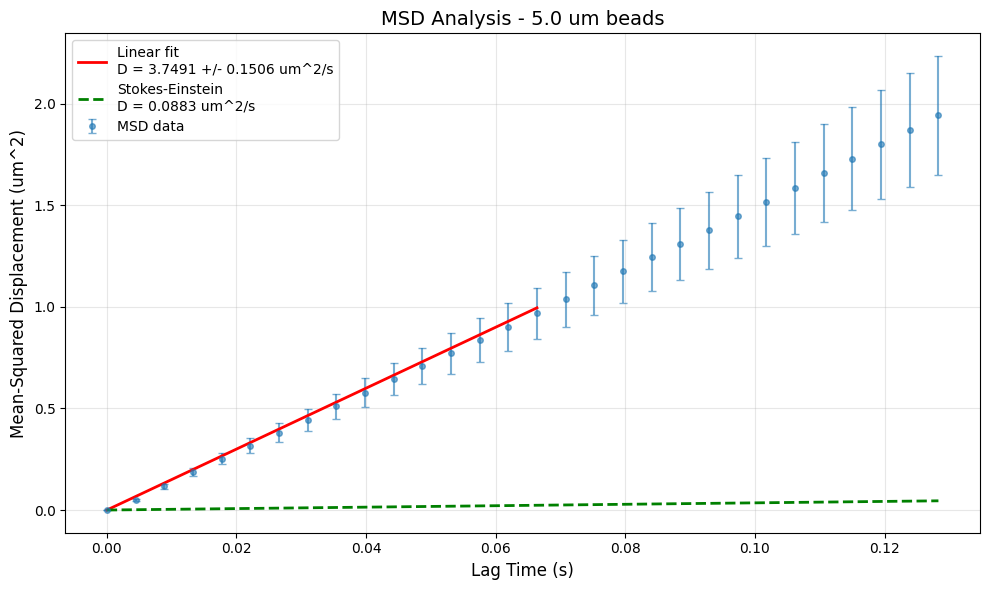

In [7]:
# MSD plots for each bead size
for bead_d, res in all_results.items():
    lag_times = res['lag_times']
    MSD_um = res['MSD_um']
    MSD_err_um = res['MSD_err_um']
    D_msd = res['D_msd']
    D_msd_err = res['D_msd_err']
    D_theory = res['D_theory']
    slope = res['msd_slope']
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(lag_times, MSD_um, yerr=MSD_err_um, fmt='o',
                 markersize=4, capsize=3, alpha=0.6, label='MSD data')
    
    # Fit line
    n_fit = min(15, len(lag_times) // 2)
    fit_line = linear(lag_times[:n_fit+1], slope, 0)
    plt.plot(lag_times[:n_fit+1], fit_line, 'r-', linewidth=2,
             label=f'Linear fit\nD = {D_msd:.4f} +/- {D_msd_err:.4f} um^2/s')
    
    # Theory line
    theory_msd = 4 * D_theory * lag_times
    plt.plot(lag_times, theory_msd, 'g--', linewidth=2,
             label=f'Stokes-Einstein\nD = {D_theory:.4f} um^2/s')
    
    plt.xlabel('Lag Time (s)', fontsize=12)
    plt.ylabel('Mean-Squared Displacement (um^2)', fontsize=12)
    plt.title(f'MSD Analysis - {res["label"]}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## Summary of Results

In [8]:
# ============================================================================
# INDIVIDUAL BEAD SIZE SUMMARIES
# ============================================================================
for bead_d, res in all_results.items():
    print("=" * 60)
    print(f"DIFFUSION COEFFICIENT SUMMARY - {res['label'].upper()}")
    print("=" * 60)
    
    print(f"\nExperimental Setup:")
    print(f"  Bead diameter: {bead_d} um")
    print(f"  Temperature: {TEMPERATURE} K ({TEMPERATURE-273.15:.1f} C)")
    print(f"  Frame rate: {FRAME_RATE} fps")
    print(f"  Pixel size: {PIXEL_SIZE} um/px ({PIXEL_SIZE*1000:.0f} nm)")
    
    print(f"\nData Quality:")
    print(f"  Track segments used: {res['n_segments']}")
    print(f"  Total displacement steps: {res['n_steps']}")
    print(f"  Drift correction: {'ON' if SUBTRACT_DRIFT else 'OFF'}")
    
    print(f"\nDiffusion Coefficient Results:")
    print(f"  Method 1 (Direct variance):  D = {res['D_direct']:.4f} um^2/s")
    print(f"  Method 2 (Gaussian fit):     D = {res['D_fit']:.4f} um^2/s")
    print(f"  Method 3 (MSD slope):        D = {res['D_msd']:.4f} +/- {res['D_msd_err']:.4f} um^2/s")
    print(f"  Stokes-Einstein prediction:  D = {res['D_theory']:.4f} um^2/s")
    
    print(f"\nComparison with Theory (D_exp/D_theory):")
    print(f"  Method 1: {res['D_direct']/res['D_theory']:.2f}x")
    print(f"  Method 2: {res['D_fit']/res['D_theory']:.2f}x")
    print(f"  Method 3: {res['D_msd']/res['D_theory']:.2f}x")
    print()

DIFFUSION COEFFICIENT SUMMARY - 1.0 UM BEADS

Experimental Setup:
  Bead diameter: 1.0 um
  Temperature: 294.15 K (21.0 C)
  Frame rate: 226 fps
  Pixel size: 0.345 um/px (345 nm)

Data Quality:
  Track segments used: 10
  Total displacement steps: 2296
  Drift correction: ON

Diffusion Coefficient Results:
  Method 1 (Direct variance):  D = 8.7092 um^2/s
  Method 2 (Gaussian fit):     D = 8.9058 um^2/s
  Method 3 (MSD slope):        D = 12.8773 +/- 0.2132 um^2/s
  Stokes-Einstein prediction:  D = 0.4414 um^2/s

Comparison with Theory (D_exp/D_theory):
  Method 1: 19.73x
  Method 2: 20.17x
  Method 3: 29.17x

DIFFUSION COEFFICIENT SUMMARY - 5.0 UM BEADS

Experimental Setup:
  Bead diameter: 5.0 um
  Temperature: 294.15 K (21.0 C)
  Frame rate: 226 fps
  Pixel size: 0.345 um/px (345 nm)

Data Quality:
  Track segments used: 10
  Total displacement steps: 2370
  Drift correction: ON

Diffusion Coefficient Results:
  Method 1 (Direct variance):  D = 2.7321 um^2/s
  Method 2 (Gaussian fit)

## Comparison Between Bead Sizes

According to Stokes-Einstein: $D = \frac{k_B T}{6 \pi \eta r}$

Therefore: $D \propto 1/r$ (inverse relationship with radius)

Expected ratio: $\frac{D_{1\mu m}}{D_{5\mu m}} = \frac{r_{5\mu m}}{r_{1\mu m}} = 5$

COMPARISON BETWEEN BEAD SIZES

Bead Size    D_direct       D_fit          D_MSD          D_theory      
(um)         (um^2/s)       (um^2/s)       (um^2/s)       (um^2/s)      
--------------------------------------------------------------------
1.0          8.7092         8.9058         12.8773        0.4414        
5.0          2.7321         2.0602         3.7491         0.0883        

------------------------------------------------------------
RATIO D(1um) / D(5um) - Expected: 5.0
------------------------------------------------------------
  Method 1 (Direct):  3.19
  Method 2 (Fit):     4.32
  Method 3 (MSD):     3.43
  Theory:             5.00


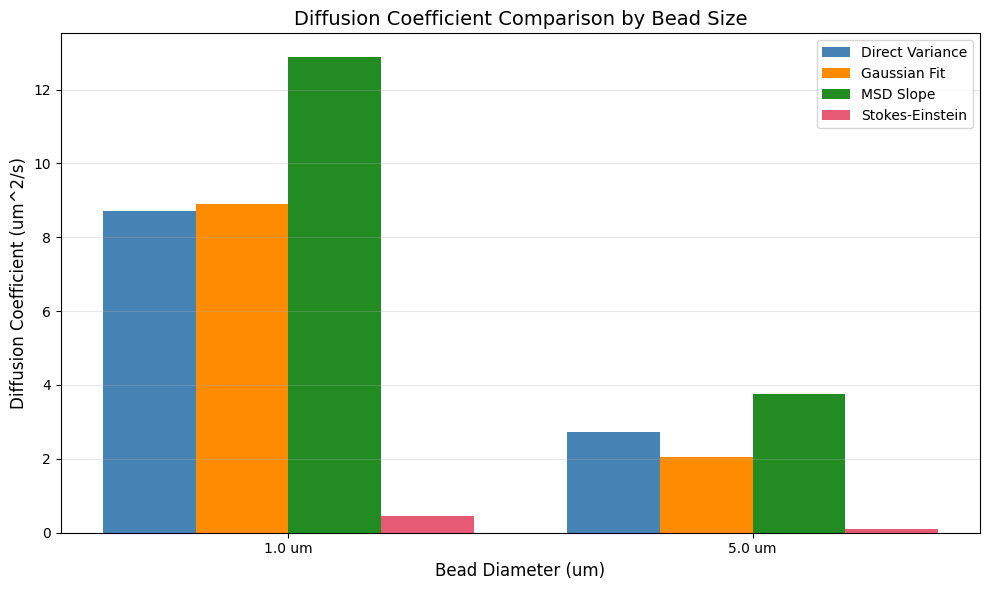

In [9]:
# ============================================================================
# COMPARISON BETWEEN BEAD SIZES
# ============================================================================
print("=" * 60)
print("COMPARISON BETWEEN BEAD SIZES")
print("=" * 60)

if len(all_results) >= 2:
    bead_sizes = sorted(all_results.keys())
    
    # Create comparison table
    print(f"\n{'Bead Size':<12} {'D_direct':<14} {'D_fit':<14} {'D_MSD':<14} {'D_theory':<14}")
    print(f"{'(um)':<12} {'(um^2/s)':<14} {'(um^2/s)':<14} {'(um^2/s)':<14} {'(um^2/s)':<14}")
    print("-" * 68)
    
    for bead_d in bead_sizes:
        res = all_results[bead_d]
        print(f"{bead_d:<12.1f} {res['D_direct']:<14.4f} {res['D_fit']:<14.4f} "
              f"{res['D_msd']:<14.4f} {res['D_theory']:<14.4f}")
    
    # Calculate ratios if we have both 1um and 5um
    if 1.0 in all_results and 5.0 in all_results:
        res_1 = all_results[1.0]
        res_5 = all_results[5.0]
        
        print(f"\n" + "-" * 60)
        print(f"RATIO D(1um) / D(5um) - Expected: 5.0")
        print("-" * 60)
        print(f"  Method 1 (Direct):  {res_1['D_direct']/res_5['D_direct']:.2f}")
        print(f"  Method 2 (Fit):     {res_1['D_fit']/res_5['D_fit']:.2f}")
        print(f"  Method 3 (MSD):     {res_1['D_msd']/res_5['D_msd']:.2f}")
        print(f"  Theory:             {res_1['D_theory']/res_5['D_theory']:.2f}")
    
    # Bar chart comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(bead_sizes))
    width = 0.2
    
    d_direct = [all_results[b]['D_direct'] for b in bead_sizes]
    d_fit = [all_results[b]['D_fit'] for b in bead_sizes]
    d_msd = [all_results[b]['D_msd'] for b in bead_sizes]
    d_theory = [all_results[b]['D_theory'] for b in bead_sizes]
    
    bars1 = ax.bar(x - 1.5*width, d_direct, width, label='Direct Variance', color='steelblue')
    bars2 = ax.bar(x - 0.5*width, d_fit, width, label='Gaussian Fit', color='darkorange')
    bars3 = ax.bar(x + 0.5*width, d_msd, width, label='MSD Slope', color='forestgreen')
    bars4 = ax.bar(x + 1.5*width, d_theory, width, label='Stokes-Einstein', color='crimson', alpha=0.7)
    
    ax.set_xlabel('Bead Diameter (um)', fontsize=12)
    ax.set_ylabel('Diffusion Coefficient (um^2/s)', fontsize=12)
    ax.set_title('Diffusion Coefficient Comparison by Bead Size', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{b} um' for b in bead_sizes])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

else:
    print("\nNeed at least 2 bead sizes for comparison.")
    print("Check that data files exist and can be loaded.")

print("\n" + "=" * 60)

## Final Summary Table

In [10]:
# ============================================================================
# FINAL SUMMARY TABLE
# ============================================================================
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print(f"\nExperimental Conditions:")
print(f"  Temperature: {TEMPERATURE} K ({TEMPERATURE-273.15:.1f} C)")
print(f"  Viscosity: {VISCOSITY:.6f} Pa.s")
print(f"  Frame rate: {FRAME_RATE} fps")
print(f"  Pixel size: {PIXEL_SIZE} um/px")

print(f"\nAnalysis Parameters:")
print(f"  Track split threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame")
print(f"  Min segment length: {MIN_TRACK_LENGTH} frames")
print(f"  Max segments used: {NUM_BEST_SEGMENTS}")
print(f"  Drift correction: {'ON' if SUBTRACT_DRIFT else 'OFF'}")

print(f"\n" + "-" * 70)
print(f"{'Bead':<8} {'Segments':<10} {'Steps':<8} {'D_MSD':<16} {'D_theory':<14} {'Ratio'}")
print(f"{'(um)':<8} {'used':<10} {'total':<8} {'(um^2/s)':<16} {'(um^2/s)':<14} {'exp/theory'}")
print("-" * 70)

for bead_d in sorted(all_results.keys()):
    res = all_results[bead_d]
    d_str = f"{res['D_msd']:.4f} +/- {res['D_msd_err']:.4f}"
    ratio = res['D_msd'] / res['D_theory']
    print(f"{bead_d:<8.1f} {res['n_segments']:<10} {res['n_steps']:<8} "
          f"{d_str:<16} {res['D_theory']:<14.4f} {ratio:.2f}x")

print("=" * 70)

FINAL SUMMARY

Experimental Conditions:
  Temperature: 294.15 K (21.0 C)
  Viscosity: 0.000976 Pa.s
  Frame rate: 226 fps
  Pixel size: 0.345 um/px

Analysis Parameters:
  Track split threshold: 20 px/frame
  Min segment length: 20 frames
  Max segments used: 10
  Drift correction: ON

----------------------------------------------------------------------
Bead     Segments   Steps    D_MSD            D_theory       Ratio
(um)     used       total    (um^2/s)         (um^2/s)       exp/theory
----------------------------------------------------------------------
1.0      10         2296     12.8773 +/- 0.2132 0.4414         29.17x
5.0      10         2370     3.7491 +/- 0.1506 0.0883         42.47x
